# Classification on imbalanced data

## 0. Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 1. Data processing and exploration

### i. Download the Kaggle Credit Card Fraud data set

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### ii. Examine the class label imbalance

In [5]:
# Let's look at the dataset imbalance:

neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### iii. Clean, split and normalize the data

In [6]:
# The raw data has a few issues. First the Time and Amount columns are too variable to use directly. 
# Drop the Time column (since it's not clear what it means) and take the log of the Amount column to reduce its range.


cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [7]:
# Split the dataset into train, validation, and test sets. 


# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
# Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### iv. Look at the data distribution

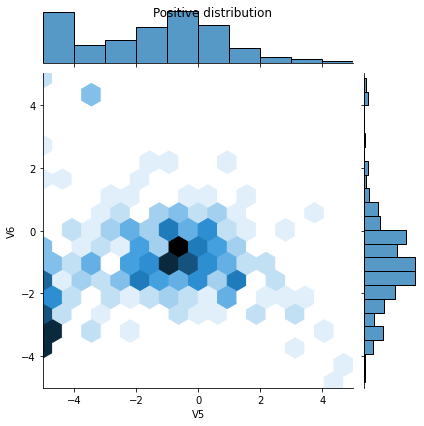

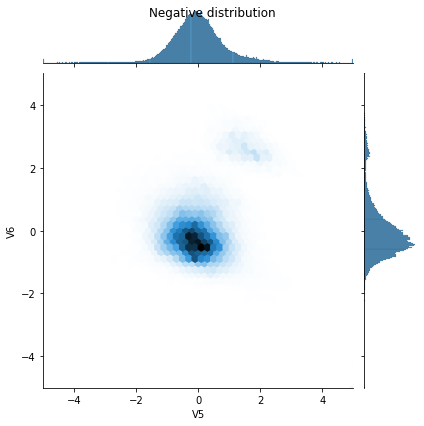

In [11]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## 2. Define the model and metrics

In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### i. Understanding useful metrics

## 3. Baseline model

### i. Build the model

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [15]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.predict(train_features[:10])

array([[0.79618126],
       [0.78890467],
       [0.38064027],
       [0.72778004],
       [0.8277519 ],
       [0.77121544],
       [0.850095  ],
       [0.5931148 ],
       [0.81816316],
       [0.5979161 ]], dtype=float32)

### ii. Optional: Set the correct initial bias.

In [17]:
# With the default bias initialization the loss should be about math.log(2) = 0.69314

results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4898


In [18]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [19]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00216965],
       [0.00334952],
       [0.00125459],
       [0.00156549],
       [0.00170543],
       [0.00192529],
       [0.00238703],
       [0.01687107],
       [0.00064038],
       [0.00241122]], dtype=float32)

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0152


### iii. Checkpoint the initial weights

In [21]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### iv. Confirm that the bias fix helps

In [22]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [23]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [24]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

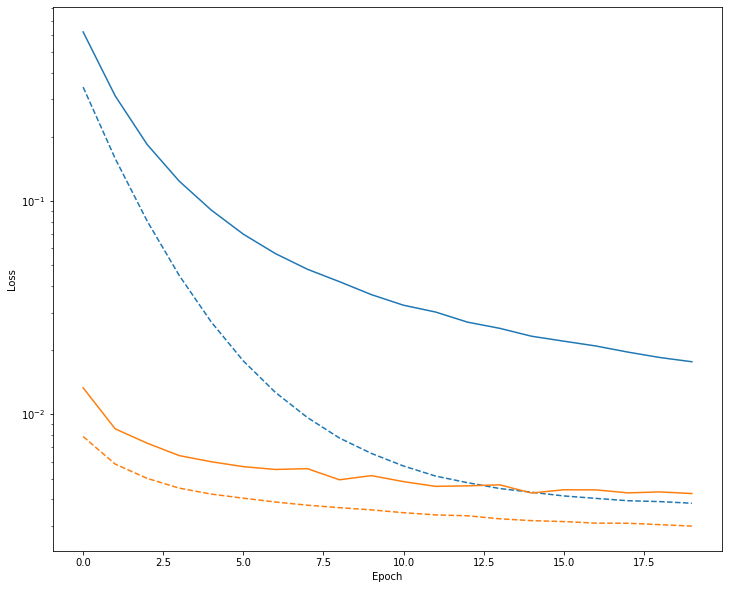

In [25]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

### v. Train the model

In [26]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 17ms/step - loss: 0.0159 - tp: 63.1099 - fp: 57.4176 - tn: 139406.6484 - fn: 182.3956 - accuracy: 0.9984 - precision: 0.5382 - recall: 0.3037 - auc: 0.7603 - val_loss: 0.0080 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 45488.0000 - val_fn: 71.0000 - val_accuracy: 0.9984 - val_precision: 0.8000 - val_recall: 0.1013 - val_auc: 0.8836
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0096 - tp: 34.5495 - fp: 9.8901 - tn: 93959.5934 - fn: 136.5385 - accuracy: 0.9984 - precision: 0.7676 - recall: 0.1752 - auc: 0.8323 - val_loss: 0.0058 - val_tp: 28.0000 - val_fp: 7.0000 - val_tn: 45483.0000 - val_fn: 51.0000 - val_accuracy: 0.9987 - val_precision: 0.8000 - val_recall: 0.3544 - val_auc: 0.9170
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0075 - tp: 57.2857 - fp: 12.5824 - tn: 93958.1209 - fn: 112.5824 - accuracy: 0.9986 - precision: 0.8122 - recall: 0.3362 - auc: 0.8801 - val_loss

### vi. Check training history

In [31]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

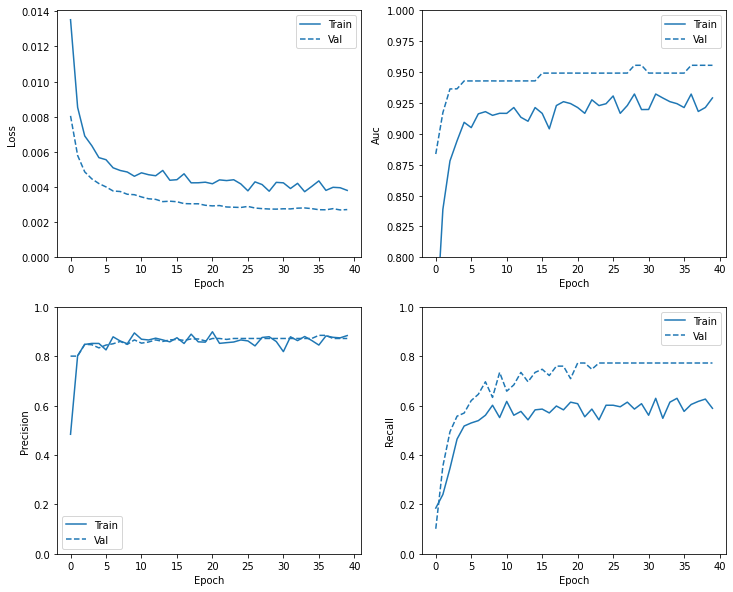

In [32]:
plot_metrics(baseline_history)

### vii. Evaluate metrics

In [33]:
# You can use a confusion matrix to summarize the actual vs. predicted labels 
# where the X axis is the predicted label and the Y axis is the actual label.

train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [35]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.003337276168167591
tp :  68.0
fp :  9.0
tn :  56861.0
fn :  24.0
accuracy :  0.9994206428527832
precision :  0.8831169009208679
recall :  0.739130437374115
auc :  0.9126824736595154

Legitimate Transactions Detected (True Negatives):  56861
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  68
Total Fraudulent Transactions:  92


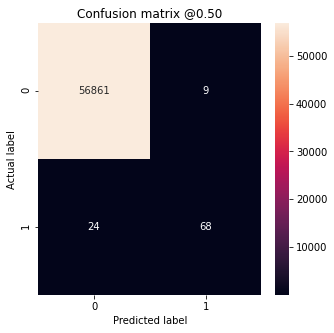

In [36]:
# Evaluate your model on the test dataset and display the results for the metrics you created above.

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### viii. Plot the ROC

In [37]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

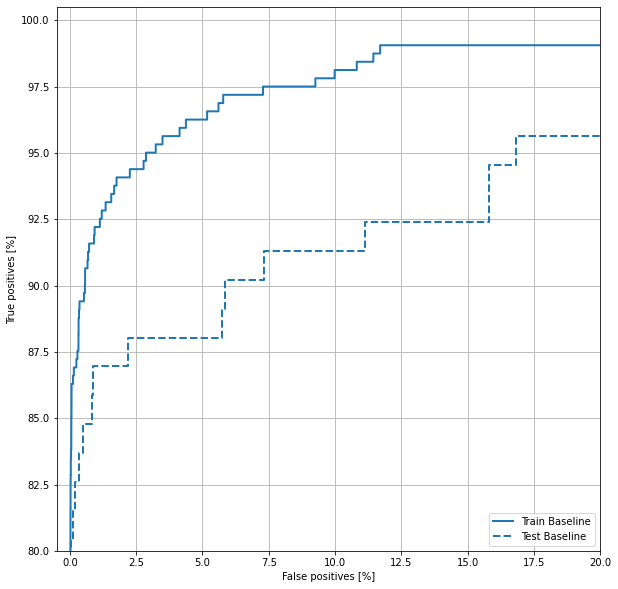

In [38]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## 4. Class weights

### i. Calculate class weights

In [39]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### ii. Train a model with class weights

In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 3s 18ms/step - loss: 2.8731 - tp: 85.9670 - fp: 168.5714 - tn: 150678.2308 - fn: 169.8022 - accuracy: 0.9979 - precision: 0.4024 - recall: 0.3689 - auc: 0.7753 - val_loss: 0.0103 - val_tp: 33.0000 - val_fp: 35.0000 - val_tn: 45455.0000 - val_fn: 46.0000 - val_accuracy: 0.9982 - val_precision: 0.4853 - val_recall: 0.4177 - val_auc: 0.9223
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 1.3387 - tp: 78.1429 - fp: 403.4286 - tn: 93561.0110 - fn: 97.9890 - accuracy: 0.9948 - precision: 0.1737 - recall: 0.4369 - auc: 0.8485 - val_loss: 0.0142 - val_tp: 56.0000 - val_fp: 82.0000 - val_tn: 45408.0000 - val_fn: 23.0000 - val_accuracy: 0.9977 - val_precision: 0.4058 - val_recall: 0.7089 - val_auc: 0.9504
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.8067 - tp: 105.7802 - fp: 698.7582 - tn: 93270.1319 - fn: 65.9011 - accuracy: 0.9923 - precision: 0.1375 - recall: 0.6015 - auc: 0.9008 - va

### iii. Check training history

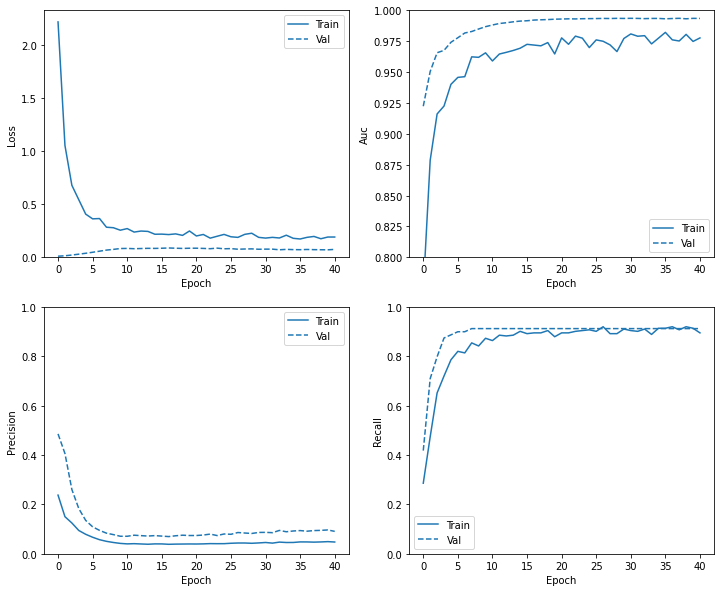

In [41]:
plot_metrics(weighted_history)

### iv. Evaluate metrics

In [42]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07849564403295517
tp :  81.0
fp :  957.0
tn :  55913.0
fn :  11.0
accuracy :  0.9830062389373779
precision :  0.07803468406200409
recall :  0.8804348111152649
auc :  0.9790670275688171

Legitimate Transactions Detected (True Negatives):  55913
Legitimate Transactions Incorrectly Detected (False Positives):  957
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  92


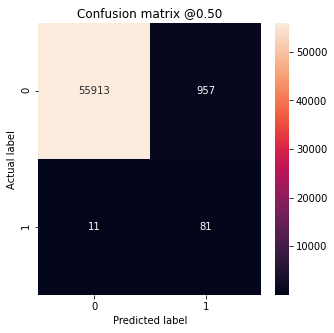

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

### v. Plot the ROC

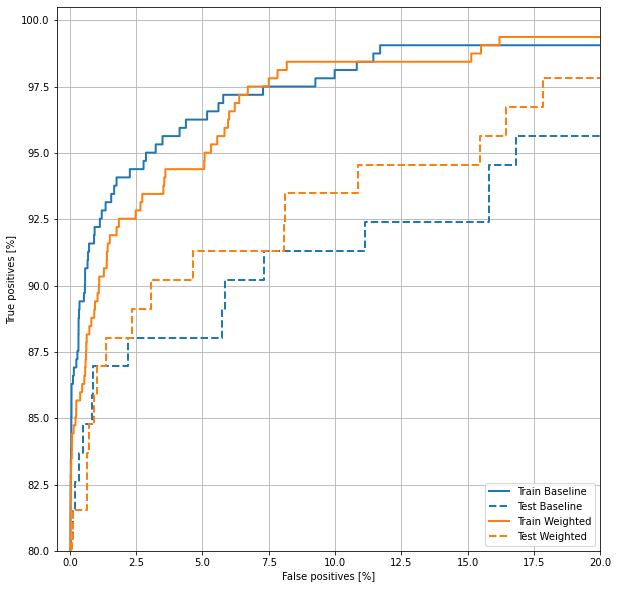

In [44]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## 5. Oversampling

### i. Oversample the minority class

In [45]:
# A related approach would be to resample the dataset by oversampling the minority class.

pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

### Using NumPy

In [46]:
# You can balance the dataset manually by choosing the right number of random indices from the positive examples:

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181955, 29)

In [47]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363910, 29)

### Using tf.data

In [48]:
# If you're using tf.data the easiest way to produce balanced examples is to start with a positive and a negative dataset, 
# and merge them. See the tf.data guide for more examples.

BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [49]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.74574422  1.19498245 -0.71200519  1.99051727  0.05252854 -0.59063922
 -0.96087882  0.56363168 -1.24151431 -2.68450849  0.29425802 -3.2485956
 -0.46753198 -5.         -1.42642551 -1.0864372  -3.19030676 -0.75619504
 -1.14063525  0.06390788  0.23869788 -0.37631588 -0.05143778 -0.67421439
  0.3024295  -0.21764648  0.1815229  -0.12531291 -1.45084486]

Label:  1


In [52]:
# Merge the two together using experimental.sample_from_datasets:

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [53]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5048828125


In [54]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### ii. Train on the oversampled data

In [55]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 6s 15ms/step - loss: 0.6147 - tp: 117116.8530 - fp: 51472.0287 - tn: 148841.0036 - fn: 26244.7742 - accuracy: 0.7686 - precision: 0.6462 - recall: 0.7675 - auc: 0.8661 - val_loss: 0.2393 - val_tp: 72.0000 - val_fp: 1273.0000 - val_tn: 44217.0000 - val_fn: 7.0000 - val_accuracy: 0.9719 - val_precision: 0.0535 - val_recall: 0.9114 - val_auc: 0.9826
Epoch 2/100
278/278 [==============================] - 3s 12ms/step - loss: 0.2185 - tp: 129425.8459 - fp: 8715.2832 - tn: 134582.2688 - fn: 13989.2616 - accuracy: 0.9178 - precision: 0.9323 - recall: 0.9011 - auc: 0.9714 - val_loss: 0.1153 - val_tp: 73.0000 - val_fp: 871.0000 - val_tn: 44619.0000 - val_fn: 6.0000 - val_accuracy: 0.9808 - val_precision: 0.0773 - val_recall: 0.9241 - val_auc: 0.9904
Epoch 3/100
278/278 [==============================] - 3s 12ms/step - loss: 0.1593 - tp: 131004.6559 - fp: 5371.6953 - tn: 138008.1864 - fn: 12328.1219 - accuracy: 0.9375 - precision: 0.9599 - r

### iii. Check training history

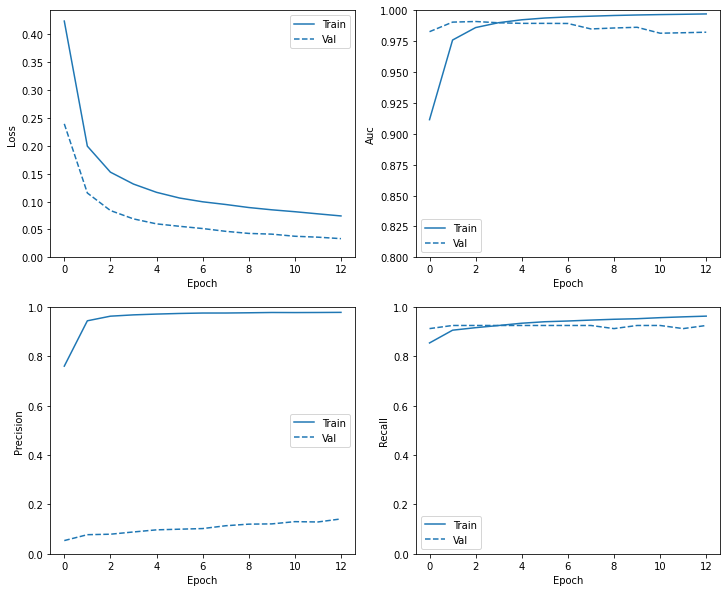

In [56]:
plot_metrics(resampled_history)

### vi. Re-train
Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the callbacks.EarlyStopping finer control over when to stop training.

In [57]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 2s 56ms/step - loss: 1.0507 - tp: 6052.2857 - fp: 6632.0476 - tn: 49949.3333 - fn: 5365.8095 - accuracy: 0.8344 - precision: 0.4557 - recall: 0.5098 - auc: 0.8778 - val_loss: 0.8124 - val_tp: 66.0000 - val_fp: 25325.0000 - val_tn: 20165.0000 - val_fn: 13.0000 - val_accuracy: 0.4440 - val_precision: 0.0026 - val_recall: 0.8354 - val_auc: 0.7713
Epoch 2/1000
20/20 [==============================] - 0s 21ms/step - loss: 0.7131 - tp: 8130.9524 - fp: 5795.5238 - tn: 5410.5714 - fn: 3093.4286 - accuracy: 0.5992 - precision: 0.5806 - recall: 0.7181 - auc: 0.6959 - val_loss: 0.7519 - val_tp: 71.0000 - val_fp: 22300.0000 - val_tn: 23190.0000 - val_fn: 8.0000 - val_accuracy: 0.5105 - val_precision: 0.0032 - val_recall: 0.8987 - val_auc: 0.8913
Epoch 3/1000
20/20 [==============================] - 0s 21ms/step - loss: 0.5746 - tp: 9194.0000 - fp: 5074.5714 - tn: 6027.7143 - fn: 2134.1905 - accuracy: 0.6720 - precision: 0.6380 - recall: 0.8060 

### v. Re-check training history

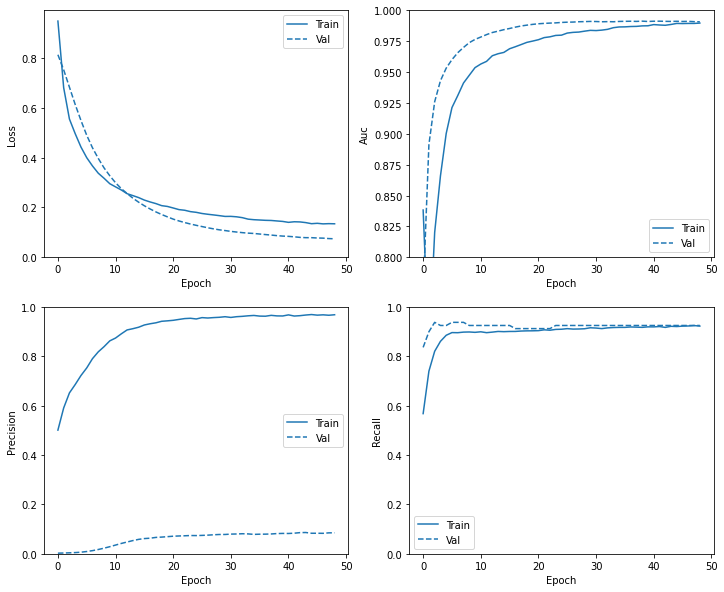

In [58]:
plot_metrics(resampled_history)

### vi. Evaluate metrics

In [59]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.087514229118824
tp :  79.0
fp :  996.0
tn :  55874.0
fn :  13.0
accuracy :  0.9822864532470703
precision :  0.07348836958408356
recall :  0.8586956262588501
auc :  0.9630388021469116

Legitimate Transactions Detected (True Negatives):  55874
Legitimate Transactions Incorrectly Detected (False Positives):  996
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  92


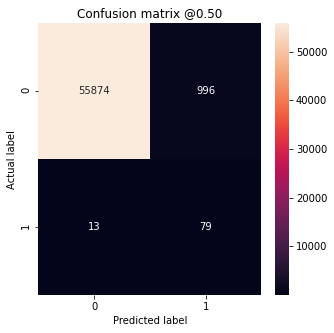

In [60]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### vii. Plot the ROC

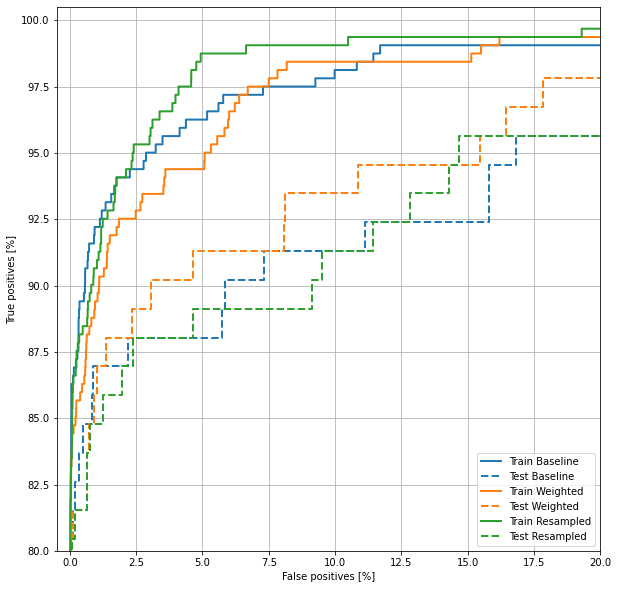

In [61]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## 6. Applying this tutorial to your problem

# reference

### https://tensorflow.google.cn/tutorials/structured_data/imbalanced_data#re-check_training_history